# Relative motion estimation between 2 frames

## 1. Import libraries vs. images

In [1]:
import matplotlib.pyplot as plt
import cv2
import json
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

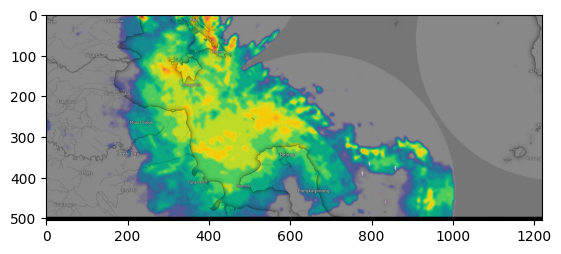

In [3]:
from src.preprocessing import read_image

SOURCE_PATH = "data/images/malaysia_-1.464_106.013"

img_paths = [
    os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.png')
]

src_images = [read_image(path) for path in img_paths]
plt.imshow(src_images[0])
plt.show()

## 2. Identification
For each storm map at each time frame, identify the storm cells. In this notebook, we provide two different approaches:
1. Simple contour identification: identify single cell as contiguous region of area.
2. Subcells contour identification: first identify cell by contiguous region of area, then splitting into subcells as local region of high-reflecttivity of centroids.

### 2.1 Extract the contours

| Variable | Description |
| --- | --- |
| *contours_time* | a list of *contours_dbz* set in vary of time. |
| *contours_dbz* | a list of *contours* set in vary of DBz. |
| *contours* | a list of *contour* of a dbz in a specific time. |
| *contour* | a list of *points* which is of shape (1, 2). |

100%|██████████| 11/11 [00:05<00:00,  1.97it/s]
Drawing contours: 11it [00:00, 1176.34it/s]


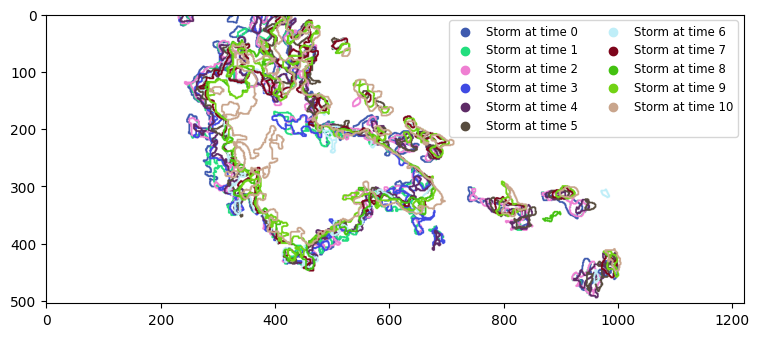

In [4]:
from src.identification import SimpleContourIdentifier, SubcellStormIdentifier
from tqdm import tqdm

contours_identifier = SimpleContourIdentifier()
subcell_identifier = SubcellStormIdentifier()

contours_time = [contours_identifier.identify_storm(img, threshold=30, filter_area=100) for img in tqdm(src_images)]
# Plot contours
plt.figure(figsize=(9, 9))

blank_img = np.ones_like(src_images[0], dtype=np.uint8) * 255
np.random.seed(2025)
color_set = np.random.randint(0, 256, size=(len(contours_time), 3), dtype=np.uint8)

for i, (contours_dbz, color) in tqdm(enumerate(zip(contours_time, color_set)), desc="Drawing contours"):
    color = tuple(int(c) for c in color)
    scaled_color = tuple(c / 255.0 for c in color)

    for contour in contours_dbz:
        cv2.drawContours(blank_img, [contour], -1, color, 2)
    plt.scatter([], [], c=[scaled_color], label=f"Storm at time {i}")

plt.imshow(blank_img)
plt.legend(loc="upper right", fontsize='small', ncol=2)
plt.show()

## 3. Tracking algorithm
In this notebook, we implement a simple tracking algorithm using polar shape vector, where the set of points used for extracting the polar shape vector is from the points of simplified polygons of Douglas-Peucker algorithm.

### Extract and visulize simplified polygon using Douglas-Peucker algorithm

Number of polygons in time 2 before simplifying: 1612
Number of polygons in time 2 after simplifying: 73


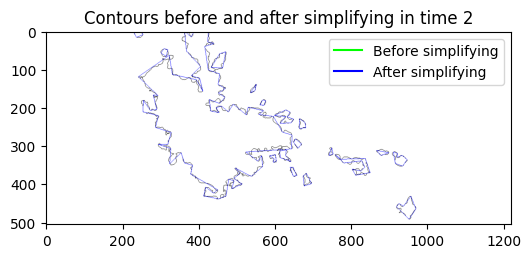

In [10]:
from src.cores.polar_description_vector import simplify_contour, construct_shape_vector

plt.figure(figsize=(6, 6))
# plt.subplot(1, 2, 1)
idx = 2
contours = contours_time[idx]
simplified_contours = [simplify_contour(contour) for contour in contours]

print(f"Number of polygons in time {idx} before simplifying: {len(contours[0])}")
print(f"Number of polygons in time {idx} after simplifying: {len(simplified_contours[0])}")

blank_img = np.ones_like(src_images[0], dtype=np.uint8) * 255
for contour, simplified_contour in zip(contours, simplified_contours):
    cv2.drawContours(blank_img, [contour], -1, color=(0, 0, 0), thickness=1)
    cv2.drawContours(blank_img, [simplified_contour], -1, color=(0, 0, 255), thickness=1)

plt.plot([], [], color=(0, 1, 0), label="Before simplifying")
plt.plot([], [], color=(0, 0, 1), label="After simplifying")

plt.title(f"Contours before and after simplifying in time {idx}")
plt.imshow(blank_img)
plt.legend()
plt.show()

### Extract vector shape features from set of simplified points

Point [[867 311]] at vertex 0 of polygon 1 in time 0
Polar shape vector:
[[ 7.95500082e+01  8.85000000e+01  3.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.68499213e+02  1.05738014e-04  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.89257192e+02 -1.76229997e-04  8.77639011e+01  2.30827076e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.52693587e+02  7.04919834e-05  1.04736099e+02  2.11795571e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.23877353e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.52460048e-05  3.52460048e-05  6.74349851e-05  1.05105828e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
--------------------
Visualization of polar shape vector:


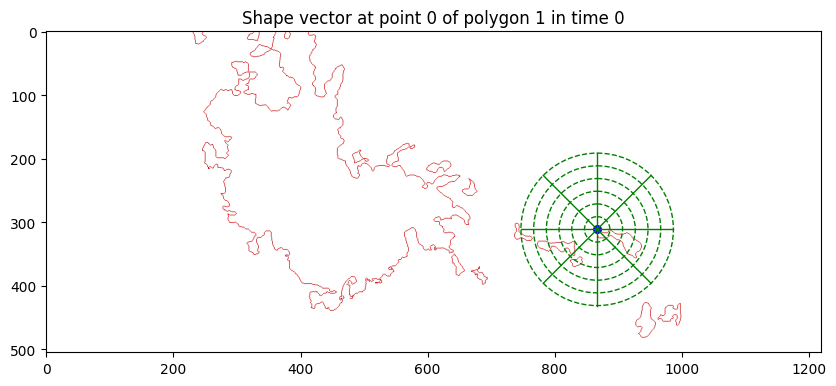

In [11]:
from src.cores.polar_description_vector import construct_shape_vector

RADII = [20, 40, 60, 80, 100, 120]
NUM_SECTORS = 8

# Choose one point to visualize
time = 0
pol_idx = 1
vertex_idx = 0
contours = contours_time[time]
point = contours[pol_idx][vertex_idx]
polar_shape_vector = construct_shape_vector(contours, point, RADII, NUM_SECTORS)

print(f"Point {point} at vertex {vertex_idx} of polygon {pol_idx} in time {time}")
print(f"Polar shape vector:\n{np.array(polar_shape_vector).reshape(6, -1)}")
print("-"*20)

print("Visualization of polar shape vector:")

def plot_shape_vector(contours: list[np.ndarray], point_A: np.ndarray, radii: list[int], num_sectors: int, ax: plt.Axes):
    blank_img = np.ones_like(src_images[0], dtype=np.int16) * 255

    # Plot polygon (assuming you have a helper function plot_contour)
    cv2.drawContours(blank_img, contours, -1, color=(200,0,0), thickness=1)

    # Add circles
    for r in radii:
        circle = plt.Circle(point_A, radius=r, color='green', fill=False, linestyle="--")
        ax.add_patch(circle)

    # Add radial lines (sectors)
    longest_r = max(radii)
    for i in range(num_sectors):
        grad_angle = np.deg2rad(i * (360 / num_sectors))
        x_start, y_start = point_A
        x_end = x_start + np.cos(grad_angle) * longest_r
        y_end = y_start + np.sin(grad_angle) * longest_r
        plt.plot([x_start, x_end], [y_start, y_end], color="green", linewidth=1)

    # Mark the reference point
    plt.scatter([point_A[0]], [point_A[1]], marker='o', s=30, color="blue", label="Point A")

    plt.imshow(blank_img)
    plt.show()

plt.figure(figsize=(10, 10))
plt.title(f"Shape vector at point {vertex_idx} of polygon {pol_idx} in time {time}")
fig = plt.gcf()
ax = fig.gca()

plot_shape_vector(contours, point.reshape(-1), RADII, NUM_SECTORS, ax)

In [72]:
import sys
del sys.modules['src.cores.polar_description_vector']
del sys.modules['src.cores']

del sys.modules['src.cores.polar_description_vector.shape_vector']

## 3. Model Tracking

In [73]:
from src.cores.polar_description_vector import StormShapeVectors, ShapeVector
from shapely import Polygon, distance
from shapely.affinity import translate

def _compute_similarity_pair(vector_1: np.ndarray, vector_2: np.ndarray, circle_area: float):
    """
        Compute similarity between two shape vectors.
    """
    return np.sum(np.abs(vector_1 - vector_2)) / circle_area

def compute_valid_pairs(
        prev_storm: StormShapeVectors,
        curr_storm: StormShapeVectors,
        circle_area: float,
        maximum_displacement: float = 20,
        thresholds: list[float] = [0.05, 0.08, 0.1]
    ) -> list[list[tuple[float, tuple[float, float]]]]:
    """
        Compute movement between two lists of shape vectors.

        Args:
            prev_storm (Storm): Previous storm instance.
            curr_storm (Storm): Current storm instance.
            circle_area (float): Area of the circle used in shape vector computation.
            maximum_displacement (float): Maximum allowed displacement between two points.
            thresholds (list[float]): List of ascending thresholds for similarity scores.

        Returns:
            List[Tuple[float, float]]: List of valid displacements.
    """
    if distance(Polygon(prev_storm.contour.reshape(-1, 2)), Polygon(curr_storm.contour.reshape(-1, 2))) > maximum_displacement:
        return []

    num_vertices = max(len(prev_storm.shape_vectors), len(curr_storm.shape_vectors))
    displacements = [[]] * len(thresholds)

    for svector_1 in prev_storm.shape_vectors:
        for svector_2 in curr_storm.shape_vectors:
            if np.linalg.norm(np.array(svector_1.coord) - np.array(svector_2.coord)) > maximum_displacement:
                continue
            score = _compute_similarity_pair(svector_1.vector, svector_2.vector, circle_area)

            for idx, threshold in enumerate(thresholds):
                if score < threshold:
                    v1, v2 = svector_1.coord, svector_2.coord
                    displacements[idx].append((v2[0]-v1[0], v2[1]-v1[1]))
    
    for idx in range(len(thresholds)):
        if len(displacements[idx]) > (num_vertices / 5):
            # print(f"Return num of valid pairs at threshold {thresholds[idx]}")
            return displacements[idx]
    
    return []

CIRCLE_AREA = RADII[-1] * RADII[-1] * np.pi

shape_vectors_1 = StormShapeVectors(contours_time[0][0])
shape_vectors_2 = StormShapeVectors(contours_time[1][0])
shape_vectors_1.extract_shape_vectors(contours_time[0], RADII, NUM_SECTORS)
shape_vectors_2.extract_shape_vectors(contours_time[1], RADII, NUM_SECTORS)

displacement_list = compute_valid_pairs(shape_vectors_1, shape_vectors_2, CIRCLE_AREA)

In [105]:
def overlapping_storm_area(contour_1: np.ndarray, contour_2: np.ndarray) -> float:
    """
    Calculate the overlapping area between two contours.
    """
    map_height = int(max(contour_1[:, 0, 1].max(), contour_2[:, 0, 1].max()) + 1)
    map_width = int(max(contour_1[:, 0, 0].max(), contour_2[:, 0, 0].max()) + 1)
    map1 = np.zeros((map_height, map_width), dtype=np.uint8)
    map2 = np.zeros((map_height, map_width), dtype=np.uint8)

    print("Map1 shape:", map1.shape)

    cv2.fillPoly(map1, [contour_1], 1)
    cv2.fillPoly(map2, [contour_2], 1)
    
    overlapping_map = cv2.bitwise_and(map1, map2)
    joint_area = cv2.bitwise_or(map1, map2)

    return np.sum(overlapping_map) / np.sum(joint_area) if np.sum(joint_area) > 0 else 0.0

overlapping_storm_area(shape_vectors_1.contour, shape_vectors_2.contour)

Map1 shape: (440, 668)


np.float64(0.8823557463042442)

### 3.1 Estimate the movement

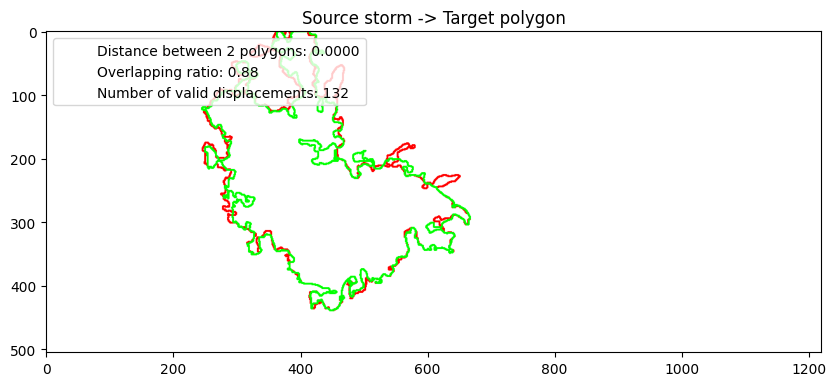

In [ ]:
from src.cores.metrics import overlapping_storm_area

CIRCLE_AREA = RADII[-1] * RADII[-1] * np.pi

shape_vectors_1 = StormShapeVectors(contours_time[0][0])
shape_vectors_2 = StormShapeVectors(contours_time[1][0])
shape_vectors_1.extract_shape_vectors(contours_time[0], RADII, NUM_SECTORS)
shape_vectors_2.extract_shape_vectors(contours_time[1], RADII, NUM_SECTORS)

displacement_list = compute_valid_pairs(shape_vectors_1, shape_vectors_2, CIRCLE_AREA)

# plot contours into the blank image
plt.figure(figsize=(10, 10))
blank_img = np.ones_like(src_images[0], dtype=np.uint8) * 255

cv2.drawContours(blank_img, [shape_vectors_1.contour], -1, color=(255,0,0), thickness=2)
cv2.drawContours(blank_img, [shape_vectors_2.contour], -1, color=(0,255,0), thickness=2)

plt.plot([], [], color=(1,1,1), label=f"Distance between 2 polygons: {distance(Polygon(shape_vectors_1.contour.reshape(-1, 2)), Polygon(shape_vectors_2.contour.reshape(-1, 2))):.4f}")
plt.plot([], [], color=(1,1,1), label=f"Overlapping ratio: {overlapping_storm_area(shape_vectors_1.contour, shape_vectors_2.contour):.2f}")
plt.plot([], [], color=(1,1,1), label=f"Number of valid displacements: {len(displacement_list)}")

plt.imshow(blank_img)
plt.title(f"Source storm -> Target polygon")
plt.legend(loc="upper left")
plt.show()

### Estimating storm motions between two contours
Methodology:
- Use K-means clustering to detect and skip those outlier points. Only remain those matching on the cluster with maximum motion.
- Estimate the overall motion of contours as mean displacement of all points.
- Use hyperparamters tunning to determine number of clustering.

In [116]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(displacement_list)
centers = kmeans.cluster_centers_
cluster_counts = np.bincount(kmeans.labels_)
max_cluster_idx = np.argmax(cluster_counts)

# displacement_vector = np.array([centers[max_cluster_idx][0], centers[max_cluster_idx][1]]).reshape(1, 1, 2)
displacement_vector = np.array([1, 1]).reshape(1, 1, 2)
predicted_polygon = shape_vectors_1.contour + displacement_vector
predicted_polygon = predicted_polygon.astype(np.int32)
overlapping = overlapping_storm_area(predicted_polygon, shape_vectors_2.contour)
print(f"Predicted displacement: {displacement_vector}")
print(f"Overlapping ratio before moving: {overlapping_storm_area(shape_vectors_1.contour, shape_vectors_2.contour)}")
print(f"Overlapping ratio after moving: {overlapping}")

Predicted displacement: [[[1 1]]]
Overlapping ratio before moving: 0.8823557463042442
Overlapping ratio after moving: 0.8809654285101618


In [117]:
from sklearn.cluster import KMeans
from shapely.affinity import translate

best_overlapping_score = 0
best_displacement = None

for num_clusters in tqdm(list(range(2, 20, 1))):
    # try:
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(displacement_list)

    centers = kmeans.cluster_centers_
    cluster_counts = np.bincount(kmeans.labels_)

    max_cluster_idx = np.argmax(cluster_counts)
    displacement_vector = np.array([centers[max_cluster_idx][0], centers[max_cluster_idx][1]]).reshape(1, 1, 2)
    
    predicted_polygon = shape_vectors_1.contour + displacement_vector
    predicted_polygon = predicted_polygon.astype(np.int32)
    overlapping = overlapping_storm_area(predicted_polygon, shape_vectors_2.contour)

    if overlapping > best_overlapping_score:
        best_overlapping_score = overlapping
        best_displacement = centers[max_cluster_idx]
    # except Exception as e:
    #     print(f"Error occurred: {e}")
    #     break

print(f"Best displacement: {best_displacement}")
print(f"Overlapping ratio: {best_overlapping_score}")

100%|██████████| 18/18 [00:00<00:00, 577.44it/s]

Best displacement: [0.475 0.125]
Overlapping ratio: 0.8823557463042442


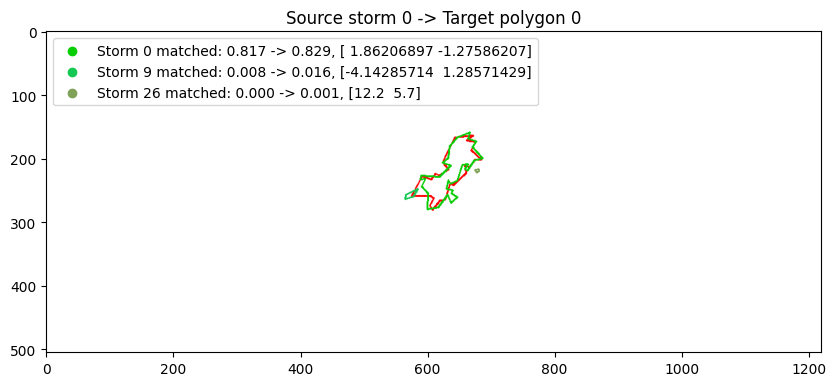

In [ ]:
r = RADII[-1]
circle_area = r * r * np.pi

prev = 1

prev_storm_idx = 0

prev_storm = storms_time[prev][prev_storm_idx]
curr_storms = storms_time[curr]

# plot contours into the blank image
plt.figure(figsize=(10, 10))
blank_img = np.ones_like(src_images[0], dtype=np.uint8) * 255

prev_polygon = prev_storm.pol
prev_contours = polygons_to_contours([prev_polygon])
cv2.drawContours(blank_img, prev_contours, -1, color=(255,0,0), thickness=2)

displacement_list_storm = []

for idx, curr_storm in enumerate(curr_storms):
    displacement_list = compute_valid_pairs(prev_storm, curr_storm, circle_area)

    if len(displacement_list) == 0:
        continue
    
    curr_polygon = curr_storm.pol
    curr_contours = polygons_to_contours([curr_polygon])

    best_overlapping_score = 0
    best_displacement = None

    for num_clusters in range(2, 20, 1):
        try:
            kmeans = KMeans(n_clusters=num_clusters)
            kmeans.fit(displacement_list)

            centers = kmeans.cluster_centers_
            cluster_counts = np.bincount(kmeans.labels_)

            max_cluster_idx = np.argmax(cluster_counts)

            predicted_polygon = translate(prev_polygon, xoff=centers[max_cluster_idx][0], yoff=centers[max_cluster_idx][1])
            overlapping = compute_overlapping([predicted_polygon], [curr_polygon])[0][0]

            if overlapping > best_overlapping_score:
                best_overlapping_score = overlapping
                best_displacement = centers[max_cluster_idx]
        except Exception as e:
            break
    
    if best_overlapping_score == 0:
        continue
    color = np.random.randint(0, 255, size=(3,), dtype=np.uint8)
    color = tuple(int(c) for c in color)
    scaled_color = tuple(c / 255.0 for c in color)
    plt.scatter([], [], c=[scaled_color], 
            label=(
                f"Storm {idx} matched: "
                f"{compute_overlapping([prev_polygon], [curr_polygon])[0][0]:.3f} -> {best_overlapping_score:.3f}, "
                f"{best_displacement}"
            ))

    displacement_list_storm.append((best_overlapping_score, best_displacement))

    cv2.drawContours(blank_img, curr_contours, -1, color=color, thickness=2)

plt.imshow(blank_img)
plt.title(f"Source storm {prev_storm_idx} -> Target polygon {curr_storm_idx}")
plt.legend(loc="upper left")
plt.show()

In [11]:
dx, dy = generate_final_displacement(displacement_list_storm, alpha=5)
print(f"Displacement: ({dx:.2f}, {dy:.2f})")

# dx, dy = displacement_list_storm[0][1]
predicted_polygon = translate(prev_polygon, xoff=dx, yoff=dy)
curr_polygons = [s.pol for s in curr_storms]

overlapping = compute_overlapping([predicted_polygon], curr_polygons)
print(np.sum(overlapping))

overlapping

Displacement: (1.92, -1.13)
0.8328205


array([[0.82767016, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00515031,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]], dtype=float32)

0.7167767 0.6602322


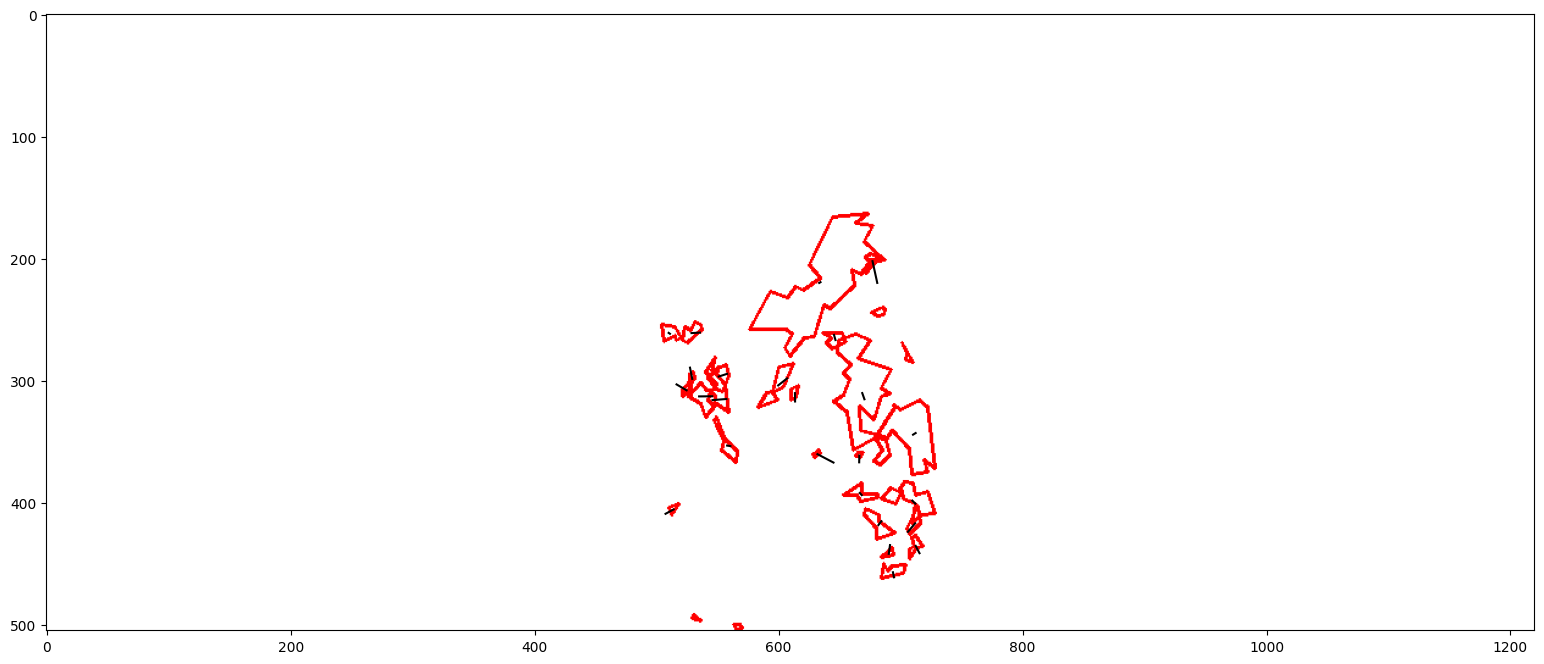

In [12]:
prev = 1
curr = 2

prev_storms = storms_time[prev]
curr_storms = storms_time[curr]

predicted_polygons = []

plt.figure(figsize=(20, 8))
blank_img = np.ones_like(src_images[0], dtype=np.uint8) * 255

for prev_storm in prev_storms:
    polygon = prev_storm.pol
    dx, dy = estimate_displacement(prev_storm, curr_storms, circle_area, alpha_smoothing=5)

    x_center, y_center = polygon.centroid.x, polygon.centroid.y
    plt.plot([x_center, x_center + dx], [y_center, y_center + dy], color=(0, 0, 0))
    predicted_polygon = translate(polygon, xoff=dx, yoff=dy)
    contours = polygons_to_contours([predicted_polygon])
    cv2.drawContours(blank_img, contours, -1, (255,0,0), thickness=2)

    predicted_polygons.append(predicted_polygon)

prev_polygons = [s.pol for s in prev_storms]
curr_polygons = [s.pol for s in curr_storms]

overlapping_matrix_prev = compute_overlapping(prev_polygons, curr_polygons)
overlapping_matrix_pred = compute_overlapping(predicted_polygons, curr_polygons)

overlapping_prev = np.sum(overlapping_matrix_prev, axis=1)
overlapping_pred = np.sum(overlapping_matrix_pred, axis=1)

areas = [pol.area for pol in predicted_polygons]
total_area = sum(areas)

overlapping_ratio_prev = sum([ratio * area / total_area for ratio, area in zip(overlapping_prev, areas)])
overlapping_ratio_pred = sum([ratio * area / total_area for ratio, area in zip(overlapping_pred, areas)])
print(overlapping_ratio_pred, overlapping_ratio_prev)

plt.imshow(blank_img)
plt.show()

In [13]:
np.argmax(overlapping_matrix_pred, axis=1)

array([ 0,  1,  1,  2,  5,  4,  2,  3, 16, 15,  0, 24,  6, 17,  5,  0,  6,
        4,  0,  2,  2,  0,  2, 14,  0,  0,  7, 12,  0])